# Construyendo una red convolucional con Keras

El código de esta notebook, exceptuando el modelo en sí, es muy similar a la notebook 1 vista en la última clase.

In [1]:
import numpy
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, regularizers

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

## Cargando los datos del MNIST


In [3]:
batch_size = 128  # For mini-batch gradient descent
num_classes = 10
epochs = 10
input_size = 28*28
train_examples = 60000
test_examples = 10000

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape the dataset to convert the examples from 2D matrixes to 1D arrays.
x_train = x_train.reshape(train_examples, input_size)
x_test = x_test.reshape(test_examples, input_size)

# normalize the input
x_train = x_train / 255
x_test = x_test / 255

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
x_train.shape

(60000, 784)

Necesitamos redimensionar el input para obtener la imagen en 2D

In [5]:
img_rows, img_cols = 28, 28  # sqrt(784)

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print(input_shape)

(28, 28, 1)


Construímos nuestro modelo agregando una [capa convolucional](https://keras.io/layers/convolutional/).

In [6]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

¿Qué tamaño tiene la salida de la primera convolución?

(???, ???, ???, ???)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [8]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          validation_steps=20)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 80us/sample - loss: 2.2873 - accuracy: 0.1419 - val_loss: 0.5783 - val_accuracy: 0.2945
Epoch 2/10
60000/60000 [==============================] - 3s 53us/sample - loss: 2.2444 - accuracy: 0.2163 - val_loss: 0.5676 - val_accuracy: 0.4797
Epoch 3/10
60000/60000 [==============================] - 3s 53us/sample - loss: 2.1998 - accuracy: 0.2986 - val_loss: 0.5558 - val_accuracy: 0.5570
Epoch 4/10
60000/60000 [==============================] - 3s 53us/sample - loss: 2.1507 - accuracy: 0.3737 - val_loss: 0.5429 - val_accuracy: 0.6004
Epoch 5/10
60000/60000 [==============================] - 3s 53us/sample - loss: 2.0959 - accuracy: 0.4341 - val_loss: 0.5285 - val_accuracy: 0.6219
Epoch 6/10
60000/60000 [==============================] - 3s 53us/sample - loss: 2.0360 - accuracy: 0.4803 - val_loss: 0.5123 - val_accuracy: 0.6422
Epoch 7/10
60000/60000 [==============================] 

# CNN para texto

A diferencia de las imágenes, el texto tiene, en principio, una sola dimensión por la cuál moverse, i.e. a través de la secuencia de palabras (eventualmente también de caracteres).

Para ver como trabajar con CNNs en texto, una forma es utilizarlas como clasificadores de texto, en particular, podemos utilizar el conjunto de datos de IMDB sobre opiniones de películas para realizar tareas de análisis de sentimiento de las opiniones.

In [9]:
%%bash

# Descargar los datos de IMDB
mkdir -p dataset
curl -L -o ./dataset/imdb_reviews.csv.gz https://cs.famaf.unc.edu.ar/~ccardellino/resources/diplodatos/imdb_reviews.csv.gz

# Descargar los word embeddings (GloVe)
curl -L -o ./dataset/glove.6B.zip https://cs.famaf.unc.edu.ar/~ccardellino/resources/diplodatos/glove.6B.zip
unzip ./dataset/glove.6B.zip glove.6B.100d.txt -d ./dataset

In [10]:
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import SVG
from gensim import corpora
from nltk import word_tokenize
from nltk.corpus import stopwords

nltk.download(["punkt", "stopwords"])

sw = set(stopwords.words("english"))

[nltk_data] Downloading package punkt to
[nltk_data]     /home/ccardellino/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ccardellino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preparación del texto

Para preparar este texto, haremos un preprocesamiento mínimo, tokenizaremos el texto, eliminaremos _stopwords_, llevaremos todo a minúsculas, y lo limitaremos a las 20000 palabras más frecuentes. 

Por otra parte, limitaremos las reviews a un máximo de 200 palabras.

### Tokenización

Cargamos el conjunto de datos (reviews de IMDB), y lo tokenizamos mediante `word_tokenize` de NLTK. Además eliminamos las _stopwords_.

A partir de estos tokens generaremos nuestro dataset. 

In [11]:
reviews = pd.read_csv("./dataset/imdb_reviews.csv.gz")
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
def review_tokenization(review):
    return [word.lower() for word in word_tokenize(review, language="english") if word.lower() not in sw]

review_tokens = reviews["review"].apply(review_tokenization).values.tolist()
target = reviews["sentiment"].map({"positive": 1, "negative": 0}).values

### Vocabulario

Con ayuda de `gensim` creamos el diccionario del vocabulario (mapeando palabras a índices). Al mismo tiempo, limitamos el tamaño del mismo a las 20000 palabras más comunes.

In [13]:
vocabulary = corpora.Dictionary(review_tokens)
vocabulary.filter_extremes(no_below=1, no_above=1.0, keep_n=20000)

## Preparación de los datos

### Dataset de TF

Ya con el vocabulario generado, podemos crear nuestro `tf.data.Dataset` para poder entrenar nuestros modelos.

Para ello tenemos que generar los ejemplos a trabajar, convirtiendo nuestros tokens a índices. Aquellos tokens que no estén en el vocabulario serán reemplazados por un token de "palabra desconocida" cuyo índice será igual al tamaño del vocabulario (recordemos que el vocabulario arranca desde el índice 0).

In [14]:
def dataset_generator():
    for rev_tok, lbl in zip(review_tokens, target):
        rev_tok_seq = vocabulary.doc2idx(rev_tok, unknown_word_index=len(vocabulary))
        yield (rev_tok_seq, lbl)

dataset = tf.data.Dataset.from_generator(
    dataset_generator, 
    output_types=(tf.int64, tf.int64)
)

# Ejemplo de como se ve nuestro dataset
for ds in dataset.take(2):
    print(ds)

(<tf.Tensor: id=16862, shape=(237,), dtype=int64, numpy=
array([   91,   104,    83,   137,     8,    94,    41,     0,    67,
           4,   105,     3,    43,    62,    82,     9,    20,     7,
          10,     9,    20,     7,    10,    50,   126,   123,    94,
          21,   132,   109,   135,     3,   112,   105,   139,    57,
           4,   129,     3,   115,    48,    64,   127,     4,   115,
         100,   101,   103,    38,     3,   113,   135,     4,    63,
           3,    28,   133, 20000,     9,    20,     7,    10,     9,
          20,     7,    10,    22,    94,    90,    55,    93,    80,
         111,   121, 20000,     4,    51,    77, 20000,    26,     3,
          45,   110,    98,    23,    56,    53,    46, 20000,     3,
          99,    65,    12,     4,    40,    26,    66, 20000,     3,
          86,     3, 20000,     3,    74,     3,    25,     3,    71,
           3,    70,     5,     6, 20000,     3,    35,   120,     3,
          37,    34,   114, 20000

### Padding de secuencias

Una vez creado nuestro dataset podemos dividirlo en los conjuntos de entrenamiento y evaluación. 

Además, tenemos que hacer _padding_ de las secuencias para normalizar el tamaño a un valor fijo (200 palabras). Para eso podemos utilizar lo que ofrece Keras. En particular, como los índices del `0` a `len(vocabulary)` están "ocupados", haremos el _padding_ con un nuevo valor igual a `len(vocabulary) + 1`.

In [15]:
TRAIN_SIZE = int(reviews.shape[0] * 0.8)
TEST_SIZE = reviews.shape[0] - TRAIN_SIZE
BATCH_SIZE = 128
MAX_SEQUENCE_LEN = 200

# First, truncate all the data to a maximum of MAX_SEQUENCE_LEN words
dataset = dataset.map(lambda data, target: (data[:MAX_SEQUENCE_LEN], target))

train_data = dataset.skip(TEST_SIZE).shuffle(TRAIN_SIZE)
test_data = dataset.take(TEST_SIZE)

# Pad the datasets
padding_shapes = ([MAX_SEQUENCE_LEN], [])  # Pad sequence up to maximum value (in this case MAX_SEQUENCE_LEN)
padding_values = (np.int64(len(vocabulary) + 1), np.int64(0))

train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)
test_data = test_data.padded_batch(BATCH_SIZE, padded_shapes=padding_shapes, padding_values=padding_values)

## Preparación del modelo

### Preparación de la matriz de embeddings

Si bien los embeddings pueden sen calculados en tiempo de entrenamiento, en general los embeddings pre-entrenados suelen tener mejores resultados y además quitan parámetros a ajustar durante el entrenamiento de la red.

Podemos cargar los embeddings de GloVe desde los archivos de texto que los definen

In [16]:
embeddings_index = {}

with open("./dataset/glove.6B.100d.txt", "r") as fh:
    for line in fh:
        values = line.split()
        word = values[0]
        if word in vocabulary.token2id:  # Only use the embeddings of words in our vocabulary
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 19137 word vectors.


Como vemos, no todas las palabras de nuestro vocabulario tienen un vector asociado, para estos casos crearemos un vector al azar. 

Además, necesitaremos crear un vector al azar para el caso de las palabras desconocidas, asociadas al índice `len(vocabulary)` y un vector de ceros asociado al índice `len(vocabulary)+1`. Por lo que nuestra matriz de embeddings tendrá un total de `len(vocabulary)+2` embeddings.

A partir de esto podemos crear nuestra matriz de embeddings con la que inicializaremos nuestra capa de embeddings en nuestro modelo.

In [17]:
EMBEDDINGS_DIM = 100  # Given by the model (in this case glove.6B.100d)

embedding_matrix = np.zeros((len(vocabulary) + 2, 100))

for widx, word in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[widx] = embedding_vector
    else:
        # Random normal initialization for words without embeddings
        embedding_matrix[widx] = np.random.normal(size=(100,))  

# Random normal initialization for unknown words
embedding_matrix[len(vocabulary)] = np.random.normal(size=(100,))

### Creación del modelo

Una vez que tenemos todos los datos necesarios, el paso final es la creación y entrenamiento del modelo utilizando las herramientas de TF y Keras.

In [18]:
FILTER_WIDTHS = [2, 3, 5]  # Take 2, 3, and 5 words
FILTER_COUNT = 64

sequence_input = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), dtype='int64', name="input")

# The embedding layer is initialized with our embedding_matrix and is not trainable
embeddings_layer = tf.keras.layers.Embedding(
    embedding_matrix.shape[0],
    EMBEDDINGS_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name="word_embedding"
)

embedded_sequences = embeddings_layer(sequence_input)

conv_layers = []
for filter_width in FILTER_WIDTHS:
    layer = tf.keras.layers.Conv1D(
        FILTER_COUNT,
        filter_width,
        activation="relu",
        name="conv_{}_words".format(filter_width)
    )(embedded_sequences)
    layer = tf.keras.layers.GlobalMaxPooling1D(name="max_pool_{}_words".format(filter_width))(layer)
    conv_layers.append(layer)

convolved_features = tf.keras.layers.Concatenate(name="convolved_features")(conv_layers)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(convolved_features)
model = tf.keras.models.Model(inputs=[sequence_input], outputs=[output], name="TextCNN")

model.compile(
    optimizer="nadam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "TextCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 200)]        0                                            
__________________________________________________________________________________________________
word_embedding (Embedding)      (None, 200, 100)     2000200     input[0][0]                      
__________________________________________________________________________________________________
conv_2_words (Conv1D)           (None, 199, 64)      12864       word_embedding[0][0]             
__________________________________________________________________________________________________
conv_3_words (Conv1D)           (None, 198, 64)      19264       word_embedding[0][0]             
____________________________________________________________________________________________

Podemos visualizar un grafo del modelo:

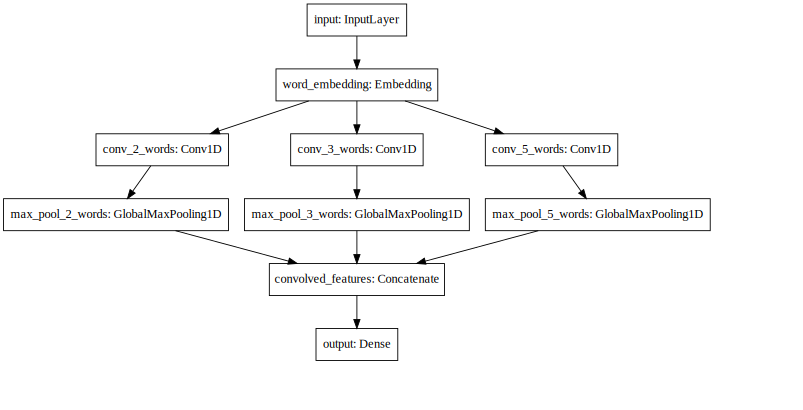

In [19]:
SVG(tf.keras.utils.model_to_dot(model, dpi=64).create(prog='dot', format='svg'))

In [20]:
model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    validation_steps=20
)

score = model.evaluate(test_data, verbose=0)
print('Test loss: {:.03f}'.format(score[0]))
print('Test accuracy: {:.03f}'.format(score[1]))

Epoch 1/10
313/313 [==============================] - 24s 77ms/step - loss: 0.4959 - accuracy: 0.7538 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
313/313 [==============================] - 21s 68ms/step - loss: 0.3497 - accuracy: 0.8482 - val_loss: 0.3543 - val_accuracy: 0.8387
Epoch 3/10
313/313 [==============================] - 22s 71ms/step - loss: 0.3002 - accuracy: 0.8744 - val_loss: 0.3372 - val_accuracy: 0.8469
Epoch 4/10
313/313 [==============================] - 22s 71ms/step - loss: 0.2670 - accuracy: 0.8927 - val_loss: 0.3156 - val_accuracy: 0.8605
Epoch 5/10
313/313 [==============================] - 23s 72ms/step - loss: 0.2398 - accuracy: 0.9075 - val_loss: 0.3070 - val_accuracy: 0.8672
Epoch 6/10
313/313 [==============================] - 23s 74ms/step - loss: 0.2087 - accuracy: 0.9211 - val_loss: 0.3040 - val_accuracy: 0.8680
Epoch 7/10
313/313 [==============================] - 21s 68ms/step - loss: 0.1864 - accuracy: 0.9329 - val_loss: 0.3254 - val_a